# Machine Learning Engineer Nanodegree
## Deep Learning
## Project: Build a Digit Recognition Program

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

----
## Step 1: Design and Test a Model Architecture
Design and implement a deep learning model that learns to recognize sequences of digits. Train the model using synthetic data generated by concatenating character images from [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) or [MNIST](http://yann.lecun.com/exdb/mnist/). To produce a synthetic sequence of digits for testing, you can for example limit yourself to sequences up to five digits, and use five classifiers on top of your deep network. You would have to incorporate an additional ‘blank’ character to account for shorter number sequences.

There are various aspects to consider when thinking about this problem:
- Your model can be derived from a deep neural net or a convolutional network.
- You could experiment sharing or not the weights between the softmax classifiers.
- You can also use a recurrent network in your deep neural net to replace the classification layers and directly emit the sequence of digits one-at-a-time.

Here is an example of a [published baseline model on this problem](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf). ([video](https://www.youtube.com/watch?v=vGPI_JvLoN0))

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [1]:
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, merge, Input
from keras.layers import Convolution2D, MaxPooling2D, MaxoutDense
from keras.datasets import mnist
from keras.utils import np_utils
from keras.callbacks import Callback
from keras.optimizers import SGD

from PIL import Image
from tqdm import tqdm
import random
import numpy as np
import cv
import pandas as pd
import h5py

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
nb_train, nb_test, nb_class, nb_digit, length = 60000, 10000, 11, 5, 28

(X_rawTrain, y_rawTrain), (X_rawTest, y_rawTest) = mnist.load_data()

In [3]:
# Generate the digits sequences
def generateSequences(nbData, rawDataX, rawDataY):
    X = np.zeros((nbData, length, length*nb_digit), dtype=np.uint8)
    Y = []
    
    # Make y fit 5 which is the number of digit categories.
    for i in range(nb_digit):
        Y.append(np.zeros((nbData, nb_class), dtype=np.uint8))
    
    for i in tqdm(xrange(nbData)):
        seqLen = random.randint(1, nb_digit)
        digitIndex = random.sample(xrange(nbData), seqLen)
        for n,index in enumerate(digitIndex):
            # n means nth dight
            X[i,:,n*length:(n+1)*length] = rawDataX[index]
            Y[n][i,rawDataY[index]] = 1
        for n in range(seqLen, nb_digit):
            Y[n][i,10] = 1 # 10 means there is no digit
    return (X, Y)

(X_train, y_train) = generateSequences(nb_train, X_rawTrain, y_rawTrain)
(X_test, y_test) = generateSequences(nb_test, X_rawTest, y_rawTest)

X_train = X_train.reshape(X_train.shape[0], length, length*nb_digit, 1)
X_test = X_test.reshape(X_test.shape[0], length, length*nb_digit, 1)    

100%|██████████| 10000/10000 [00:00<00:00, 75860.49it/s]


In [4]:
X_train.shape

(60000, 28, 140, 1)

In [4]:
inputs = Input(shape=X_train.shape[1:])

x = inputs
x = Convolution2D(32, 3, 3, activation='relu', border_mode='valid')(x)
x = Convolution2D(32, 3, 3, activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.2)(x)
x = Flatten()(x)

outs = []
for i in range(5):
    out = Dense(256, activation='relu')(x)
    out = Dense(nb_class, activation='softmax')(x)
    outs.append(out)
    
model = Model(inputs, outs)
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

In [5]:
model.fit(X_train, y_train, batch_size=200, nb_epoch=3, validation_data=(X_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 422s - loss: 1.7568 - dense_2_loss: 0.4434 - dense_4_loss: 0.4366 - dense_6_loss: 0.3720 - dense_8_loss: 0.3006 - dense_10_loss: 0.2042 - dense_2_acc: 0.8934 - dense_4_acc: 0.9012 - dense_6_acc: 0.9172 - dense_8_acc: 0.9343 - dense_10_acc: 0.9572 - val_loss: 0.3482 - val_dense_2_loss: 0.0926 - val_dense_4_loss: 0.0865 - val_dense_6_loss: 0.0718 - val_dense_8_loss: 0.0602 - val_dense_10_loss: 0.0371 - val_dense_2_acc: 0.9721 - val_dense_4_acc: 0.9737 - val_dense_6_acc: 0.9778 - val_dense_8_acc: 0.9810 - val_dense_10_acc: 0.9889
Epoch 2/3
60000/60000 [==============================] - 422s - loss: 0.2603 - dense_2_loss: 0.0728 - dense_4_loss: 0.0657 - dense_6_loss: 0.0543 - dense_8_loss: 0.0406 - dense_10_loss: 0.0268 - dense_2_acc: 0.9774 - dense_4_acc: 0.9794 - dense_6_acc: 0.9828 - dense_8_acc: 0.9874 - dense_10_acc: 0.9913 - val_loss: 0.2500 - val_dense_2_loss: 0.0636 - val_dens

### Question 1
_What approach did you take in coming up with a solution to this problem?_

**Answer:** 
At first, I use the MNIST dataset to generate sequences as training and testing set. Then I train a CNN network to pick up the features of the sequences. Finally, there are 5 classfy perceptron that can prediction the digits in a sequence one by one.

### Question 2
_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_

**Answer:**
> Input (28x140x1) -> valid-pad 3x3 Conv[32] -> same-pad 3x3 Conv[32] 
-> 2x2 max pooling (stride 1) -> dropout [0.2](x) -> Flatten

> Output: (fully-connected[256] -> softmax fully-connected[11])

### Question 3
_How did you train your model? How did you generate your synthetic dataset?_ Include examples of images from the synthetic data you constructed.

**Answer:** 
- I use the optimizer adadelta
- I joint the digits on MNIST and format the size to 28x140, the digits and the number of digits are all chosen randomly.
- Below is the example:

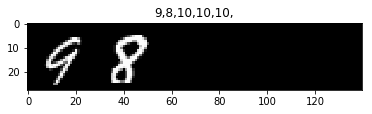

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
model.load_weights('weights')

index = random.randint(0, nb_test)
title = ''
for i in range(nb_digit):
    title += str(np.argmax(y_test[i][index])) + ','
plt.title(title)
plt.imshow(X_test[index,:,:,0], cmap='gray')

----
## Step 2: Train a Model on a Realistic Dataset
Once you have settled on a good architecture, you can train your model on real data. In particular, the [Street View House Numbers (SVHN)](http://ufldl.stanford.edu/housenumbers/) dataset is a good large-scale dataset collected from house numbers in Google Street View. Training on this more challenging dataset, where the digits are not neatly lined-up and have various skews, fonts and colors, likely means you have to do some hyperparameter exploration to perform well.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [2]:
resize_width = 45
resize_height = 45
nb_train, nb_test = 30062, 13068
nb_digit = 6

In [183]:
# Return a list with 2 element, which consist of a numpy array respectly. The first represent
# the information of the bouunding box, and the second represent the length.
def getBboxY(name, amount, sizes, scale):
    
    def bboxHelper(attr):
        if (len(attr) > 1):
            attr = [f[attr.value[j].item()].value[0][0] for j in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        return attr
    y_ = []
    y__ = np.zeros((amount, 4), dtype=np.float16)
    f = h5py.File(name + '/digitStruct.mat','r')
    bbox = f['digitStruct']['bbox']
    
    for i in range(nb_digit): # plus 1 because the one more is used to save the length
        y_.append(np.zeros((amount, 4), dtype=np.float16))
    y_.append(np.zeros((amount, nb_digit), dtype=np.float16))
    
    
    for i in tqdm(xrange(amount)):
        bb = bbox[i].item()
        seqLen = len(f[bb]["height"])
        if scale == 1:
            verticalScale = float(resize_height) / sizes[i][1]
            horizontalScale = float(resize_width) / sizes[i][0]
            #print verticalScale, horizontalScale
        else:
            verticalScale, horizontalScale = 1, 1
        
        if seqLen == 1:
                y_[0][i, 0] = f[bb]["height"].value[0][0] * verticalScale
                y_[0][i, 1] = f[bb]["left"].value[0][0] * horizontalScale
                y_[0][i, 2] = f[bb]["top"].value[0][0] * verticalScale
                y_[0][i, 3] = f[bb]["width"].value[0][0] * horizontalScale
        else:
            for j in range(seqLen):
                y_[j][i, 0] = f[f[bb]["height"].value[j].item()].value[0][0] * verticalScale
                y_[j][i, 1] = f[f[bb]["left"].value[j].item()].value[0][0] * horizontalScale
                y_[j][i, 2] = f[f[bb]["top"].value[j].item()].value[0][0] * verticalScale
                y_[j][i, 3] = f[f[bb]["width"].value[j].item()].value[0][0] * horizontalScale
        #print i, seqLen
        y_[nb_digit][i, seqLen-1] = 1   
    print [y_[i][1, 1] for i in range(3)]
    
    
    for j in range(amount):
        count = np.argmax(y_[nb_digit][j]) + 1
        widths = [y_[i][j, 3] for i in range(count)]
        lefts = [y_[i][j, 1] for i in range(count)]
        uppers = [y_[i][j, 2] for i in range(count)]
        heights = [y_[i][j, 0] for i in range(count)]
        left = int(min(lefts))
        right = int(max(lefts) + max(widths))
        lower = int(min(uppers) + max(heights))
        upper = int(min(uppers))
        #print lefts
        #print uppers
        y__[j, 0], y__[j, 1], y__[j, 2], y__[j, 3] = left, upper, right, lower 
    return y__
def obtainRawData(name, amount, crop=1):
    x = []
    xSizes = []
    
    for i in tqdm(xrange(1, amount+1)):
        image = Image.open( name + '/' + str(i) + '.png')
        xSizes.append(image.getbbox()[2:4])
        x.append(image)
    if crop == 1:
        bboxY = getBboxY(name, amount, xSizes, 0)
    
    # Cropping the images
    for i in range(amount):
        if crop == 1:
            left, upper, right, lower = bboxY[i]
            coefficient = 0.05
            left -= int(xSizes[i][0] * coefficient)
            right += int(xSizes[i][0] * coefficient + 5)
            upper -= int(xSizes[i][1] * coefficient)
            lower += int(xSizes[i][1] * coefficient)
            x[i] = x[i].crop(box = (left, upper, right, lower))
        x[i] = x[i].resize([resize_width,resize_height])
        #print resize_width,resize_height
        x[i] = np.array(x[i])

    x = np.array(x)
    x = np.rollaxis(x, 0, 4)
    x = np.reshape(x, 
                   (np.prod(x.shape[:-1]), x.shape[-1]),
                   order='C').T / 255.
    return (x, xSizes)

def obtainLabels(name, amount):
    path = name + '/digitStruct.mat'
    f = h5py.File(path, 'r')
    digitStruct = f['digitStruct']['bbox']
    y = []
    for i in tqdm(xrange(amount)):
        bb = digitStruct[i].item()
        label = f[bb]["label"]
        if(len(label) > 1):
            y.append([f[label.value[j].item()].value[0][0] for j in range(len(label))])
        else:
            y.append([label.value[0][0]])
        l = len(y[i])
        y[i].insert(0, l)
        zeros = np.zeros(7-l-1).tolist()
        y[i].extend(zeros)
    y = np.array(y)
    return y

In [191]:
#X_test, X_test_sizes = obtainRawData('test', nb_test)
#X_train, X_train_sizes = obtainRawData('train', nb_train)
X_extra, X_extra_sizes = obtainRawData('extra', nb_train)

100%|██████████| 30000/30000 [02:39<00:00, 187.53it/s]


[32.0, 143.0, 0.0]


In [193]:
y_rawTest = obtainLabels('test', nb_test)
y_rawTrain = obtainLabels('train', nb_train)
y_rawExtra = obtainLabels('extra', nb_train)

100%|██████████| 30000/30000 [00:35<00:00, 850.23it/s]


In [202]:
y_rawTrain = np.concatenate((y_rawTrain, y_rawExtra))
X_train = np.concatenate((X_train, X_extra))
nb_train *= 2

In [203]:
def formatY(y):
    y_ = []
    y = y.astype('int')
    for i in range(nb_digit):
        y_.append(np.zeros((y.shape[0], nb_class), dtype=np.uint8))
    for i in range(y.shape[0]):
        seqLen = y[i][0]
        for j in range(0, nb_digit):
            if j < seqLen:
                num = y[i][j+1]
                if num == 10:
                    num = 0
                y_[j][i, num] = 1
            else:
                y_[j][i, 10] = 1
    return y_

y_train = formatY(y_rawTrain)
y_test = formatY(y_rawTest)

In [187]:
X_train = X_train.reshape(nb_train, resize_height, resize_width, 3)
X_test = X_test.reshape(nb_test, resize_height, resize_width, 3)

In [173]:
inputs = Input(shape=(resize_height, resize_width, 3))

x = inputs
x = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(x)
x = Activation('relu')(x)
x = Convolution2D(32, 3, 3)(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

x = Convolution2D(64, 3, 3, border_mode='same')(x)
x = Activation('relu')(x)
x = Convolution2D(64, 3, 3)(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

x = Flatten()(x)
x = Dense(512)(x)
x = Dropout(0.5)(x)

outs = []
for i in range(nb_digit):
    out = Dense(512, activation='relu')(x)
    out = Dense(nb_class, activation='softmax', name='No.%d'%(i+1))(x)
    outs.append(out)

#opt = SGD(lr=0.01)
model2 = Model(inputs, outs)
model2.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

In [204]:
model2.fit(X_train, y_train, batch_size=128, nb_epoch=20, validation_data=(X_test, y_test))

Train on 60000 samples, validate on 13068 samples
Epoch 1/20
60000/60000 [==============================] - 495s - loss: 1.8671 - No.1_loss: 0.5487 - No.2_loss: 0.7235 - No.3_loss: 0.4705 - No.4_loss: 0.1181 - No.5_loss: 0.0053 - No.6_loss: 0.0011 - No.1_acc: 0.8317 - No.2_acc: 0.7822 - No.3_acc: 0.8597 - No.4_acc: 0.9678 - No.5_acc: 0.9994 - No.6_acc: 0.9999 - val_loss: 1.7089 - val_No.1_loss: 0.6085 - val_No.2_loss: 0.8188 - val_No.3_loss: 0.2514 - val_No.4_loss: 0.0285 - val_No.5_loss: 0.0017 - val_No.6_loss: 2.6718e-05 - val_No.1_acc: 0.8185 - val_No.2_acc: 0.7636 - val_No.3_acc: 0.9329 - val_No.4_acc: 0.9927 - val_No.5_acc: 0.9998 - val_No.6_acc: 1.0000
Epoch 2/20
60000/60000 [==============================] - 471s - loss: 1.6335 - No.1_loss: 0.4702 - No.2_loss: 0.6507 - No.3_loss: 0.4097 - No.4_loss: 0.0974 - No.5_loss: 0.0048 - No.6_loss: 6.9703e-04 - No.1_acc: 0.8528 - No.2_acc: 0.8030 - No.3_acc: 0.8802 - No.4_acc: 0.9730 - No.5_acc: 0.9995 - No.6_acc: 1.0000 - val_loss: 1.845

This the prediction to the samples in test set


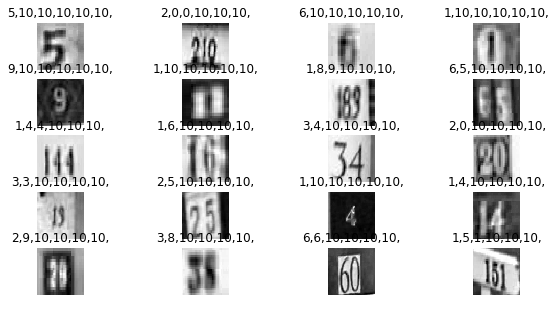

In [205]:
X_show = X_test[:20]
y_ = model2.predict(X_show)

print 'This the prediction to the samples in test set'
plt.figure(figsize=(10,5))
for i in range(20):
    plt.subplot(5, 4, i+1)
    title = ''
    for j in range(6):
        title += str(np.argmax(y_[j][i])) + ','
    plt.title(title)
    plt.imshow(X_show[i,:,:,0], cmap='gray')
    plt.axis('off')

In [206]:
prediction = model2.predict(X_test, verbose=0)

In [207]:
# Calculate the accuracy
t = 0
amount = len(y_test[0])
for i in range(amount):
    for j in range(6):
        if np.argmax(prediction[j][i]) != np.argmax(y_test[j][i]):
            break
            
    if j == 5:
        t+=1

print float(t) / amount

0.674318947046


### Question 4
_Describe how you set up the training and testing data for your model. How does the model perform on a realistic dataset?_

##### **Answer:**
- I preprocess the SVHN dataset by the information of bounding box. And in order to make the model perform better, I cropped the greater range than the original bounding box.
- At first, I cropped the images according to bounding box completely and get the accuracy at 73%. Now The loss is around 2 and the accuracy is around 55%.


### Question 5
_What changes did you have to make, if any, to achieve "good" results? Were there any options you explored that made the results worse?_

**Answer:**
I change the architecture from the simple one that you can see in *Step 1* to the complicated one that have more convolution layers, more max pooling layers, and more complicated fully connection layers. The changes made performance better.

### Question 6
_What were your initial and final results with testing on a realistic dataset? Do you believe your model is doing a good enough job at classifying numbers correctly?_

**Answer:**
In the initial result, the accuracy with testing on the realistic dataset is about 30%, which means the model is too bad to apply. And in the fianl result, the accuracy is ascend to around 55%. I noticed the inintial model with simple CNN is hard to train and the final model can fit the data well.

Although the accuracy is decreased when I enlarge the range of the bounding box. But the model perform better on realistic images.

----
## Step 3: Test a Model on Newly-Captured Images

Take several pictures of numbers that you find around you (at least five), and run them through your classifier on your computer to produce example results. Alternatively (optionally), you can try using OpenCV / SimpleCV / Pygame to capture live images from a webcam and run those through your classifier.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

100%|██████████| 5/5 [00:00<00:00, 16.10it/s]


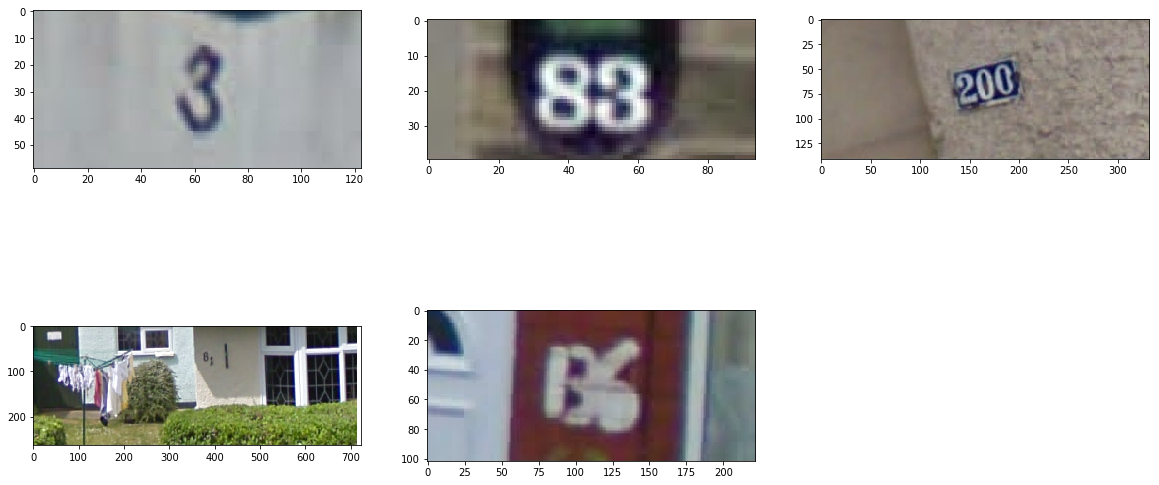

In [208]:
X_samples = []
plt.figure(figsize=(20,10))
for i in tqdm(xrange(1, 6)):
    image = Image.open( 'samples/' + str(i) + '.png')
    plt.subplot(2, 3, i)
    plt.imshow(image)
    image = image.resize([45, 45])
    image = np.array(image)
    X_samples.append(image)
X_samples = np.array(X_samples)

This the prediction to the samples in validation set


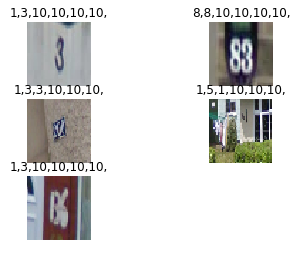

In [209]:
y_ = model2.predict(X_samples)

print 'This the prediction to the samples in validation set'
for i in range(5):
    plt.subplot(3, 2, i+1)
    title = ''
    for j in range(6):
        title += str(np.argmax(y_[j][i])) + ','
    plt.title(title)
    plt.imshow(X_samples[i,:,:,:])
    plt.axis('off')

### Question 7
_Choose five candidate images of numbers you took from around you and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult?_

**Answer:**
The atio that the area of dights of the entire photo, the contrast of color between the digits and surroundings, the size, the font, the brightness and the orientation of the digits. The operation resizing also will make the image slur.

### Question 8
_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the realistic dataset?_

**Answer:**
No, the performance is bad. From images of the 5 samples, we can see the wrong answer on both length and sigle-digit recognition. I thought the reason is that the training data is preprocessed by the provided bbox location, which means the training data eliminates the outlying information. The way making the performance eaqually well on realistic pictures compared to testing is training another model to predict the bbox location.

### Optional: Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._

**Answer:** Leave blank if you did not complete this part.

----
### Step 4: Explore an Improvement for a Model

There are many things you can do once you have the basic classifier in place. One example would be to also localize where the numbers are on the image. The SVHN dataset provides bounding boxes that you can tune to train a localizer. Train a regression loss to the coordinates of the bounding box, and then test it. 

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [174]:
resize_width = 45
resize_height = 45
nb_train = 30000
nb_digit = 6
nb_class = 11
#weights = model2.get_weights()
# import pickle
# weights2 = pickle.load(open('model2_weight', 'rb'))
# model2.set_weights(weights2)
X_test, X_test_sizes = obtainRawData('test', nb_test, crop=0)
X_train, X_train_sizes = obtainRawData('train', nb_train, crop=0)
X_extra, X_extra_sizes = obtainRawData('extra', nb_train, crop=0)

In [42]:
y_test = getBboxY('test', nb_test, X_test_sizes, scale=1)
y_train = getBboxY('train', nb_train, X_train_sizes, scale=1)
y_extra = getBboxY('extra', nb_train, X_extra_sizes, scale=1)

In [6]:
nb_train *= 2
X_train = np.concatenate((X_train, X_extra))
y_train = np.concatenate((y_train, y_extra))
X_test = X_test.reshape(nb_test, resize_height, resize_width, 3)
X_train = X_train.reshape(nb_train, resize_height, resize_width, 3)

In [168]:
# The model making predictions for bounding box
inputs = Input(shape=X_train.shape[1:])

x = inputs
x = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(x)
x = Activation('relu')(x)
x = Convolution2D(32, 3, 3)(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

x = Convolution2D(64, 3, 3, border_mode='same')(x)
x = Activation('relu')(x)
x = Convolution2D(64, 3, 3)(x)
x = Activation('relu')(x)
x = Convolution2D(64, 3, 3)(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Convolution2D(128, 3, 3, border_mode='same')(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

#outs = []

out = Dense(4, activation='linear', name='Bbox')(x)


# out = Dense(512, activation='relu')(x)
# out = Dense(5, activation='softmax', name='length')(out)
# outs.append(out)

model = Model(inputs, out)
model.compile(loss='mse', optimizer='adadelta')

This is the Distribution map of four value of the bounding box


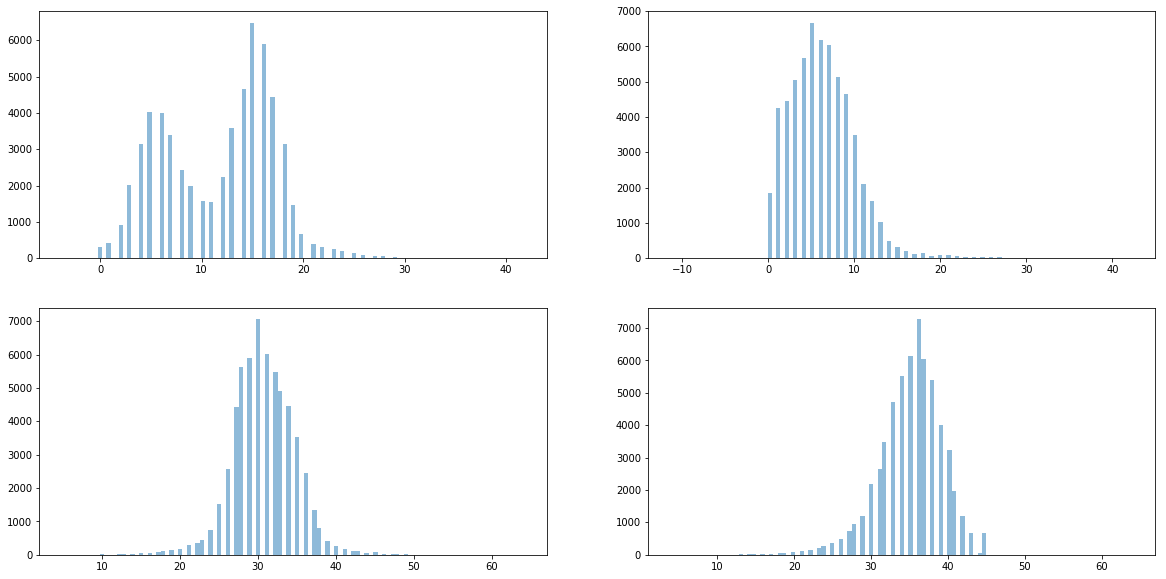

In [8]:
print 'This is the Distribution map of four value of the bounding box'
import math
plt.figure(figsize=(20,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    data = y_train[:,i]
    bins = np.linspace(math.ceil(min(data)),
                       math.floor(max(data)),
                       100)
    plt.xlim([min(data)-5, max(data)+5])
    plt.hist(data, bins=bins, alpha=0.5)
plt.show()

In [171]:
model.fit(X_train, y_train, batch_size=128, nb_epoch=20, validation_data=(X_test, y_test))

Train on 60000 samples, validate on 13068 samples
Epoch 1/20
60000/60000 [==============================] - 549s - loss: 22.9023 - val_loss: 35.8333
Epoch 2/20
60000/60000 [==============================] - 548s - loss: 20.6905 - val_loss: 39.2874
Epoch 3/20
60000/60000 [==============================] - 549s - loss: 16.5058 - val_loss: 31.2532
Epoch 4/20
60000/60000 [==============================] - 550s - loss: 14.6091 - val_loss: 25.8018
Epoch 5/20
60000/60000 [==============================] - 547s - loss: 13.4973 - val_loss: 24.0538
Epoch 6/20
60000/60000 [==============================] - 550s - loss: 12.8029 - val_loss: 26.7147
Epoch 7/20
60000/60000 [==============================] - 549s - loss: 12.2164 - val_loss: 28.1364
Epoch 8/20
60000/60000 [==============================] - 547s - loss: 11.8382 - val_loss: 19.3894
Epoch 9/20
60000/60000 [==============================] - 546s - loss: 11.4717 - val_loss: 19.5262
Epoch 10/20
60000/60000 [==============================] - 

14.757612751 4.17455969334
2.35931282522
[ 17.98270988  10.47428513  26.51499367  30.167099  ]


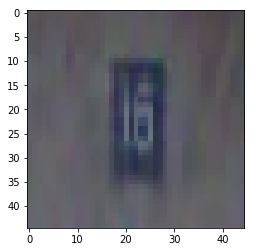

In [164]:
print score, score_train
y_pre_test = model.predict(X_test)
diff = y_pre_test.astype('int') - y_test
#print y_test[10:22]
print abs(diff).mean()
plt.imshow(X_test[21])
print y_pre_test[21]
#(left, upper, right, lower)

In [165]:
for i in range(4):
    print diff[:,i].mean()

-1.49977043159
-2.02188552189
0.503060912152
0.538950107132


This is the performance of the Bbox prediction on the testing set.


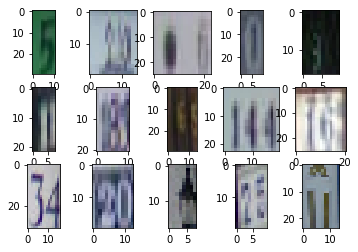

In [172]:
y_pre = model.predict(X_test[0:15])
print 'This is the performance of the Bbox prediction on the testing set.'
for j in range(0, 15):
    num = j

    #print y_pre[5][num]
    left = int(y_pre[j, 0])
    upper = int(y_pre[j, 1])
    right = int(y_pre[j, 2])
    lower = int(y_pre[j, 3])
#    print left, upper, right, lower
    image = Image.open('test/'+ str(num+1) +'.png')
    image = image.resize([resize_width, resize_height])
    plt.subplot(3,5,num+1)
    
    
    image = image.crop(box = (left, upper, right, lower))                                                                         
    #plt.title(str(num+1) + '-' + str(count))
    plt.imshow(image)
    #plt.axis('off')
# print y_test[0:5]
# print y_pre
# plt.imshow(X_test[0])

In [158]:
X_samples, X_samples_sizes = obtainRawData('samples', 5, crop=0)

y_samples_pre = model.predict(X_samples.reshape(5, resize_height, resize_width, 3))

100%|██████████| 5/5 [00:00<00:00, 268.99it/s]


Left is the original image, right is the processed image by the bbox location that is predicted by the model


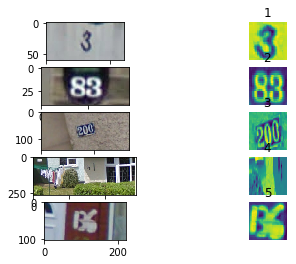

In [176]:
print 'Left is the original image, right is the processed image by the bbox location that is predicted by the model'
X_croped = []
for j in range(5):
    num = j
    #count = np.argmax(y_samples_pre[1][j]) + 1
    #print y_pre[5][num]
    left = int(y_samples_pre[j, 0])
    upper = int(y_samples_pre[j, 1]) + 1
    right = int(y_samples_pre[j, 2]) + 1
    lower = int(y_samples_pre[j, 3])
    
    # print (left, upper, right, lower)
    image = Image.open('samples/'+ str(num+1) +'.png')
    plt.subplot(5,2,(num+1)*2-1)
    plt.imshow(image)
    
    verticalScale = X_samples_sizes[j][1] / float(resize_height)
    horizontalScale =  X_samples_sizes[j][0] / float(resize_width)
    #image = image.resize([40, 20])
    image = image.crop(box = (left*horizontalScale, upper*verticalScale, right*horizontalScale, lower*verticalScale))
    image = image.resize([45, 45])
    image = np.array(image)
    X_croped.append(image)
    plt.subplot(5,2,(num+1)*2)
    plt.title(str(num+1))
    plt.imshow(image[:, :, 1])
    plt.axis('off')

X_croped = np.array(X_croped)    

This the prediction to the samples in validation set.
10 present there is no digit.


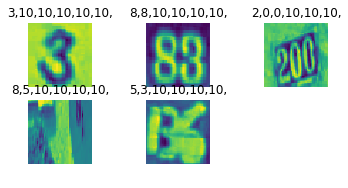

In [210]:
y_ = model2.predict(X_croped)

print 'This the prediction to the samples in validation set.'
print '10 present there is no digit.'
for i in range(5):
    plt.subplot(3, 3, i+1)
    title = ''
    for j in range(6):
        title += str(np.argmax(y_[j][i])) + ','
    plt.title(title)
    plt.imshow(X_croped[i,:,:,0])
    plt.axis('off')

In [211]:
X_test, X_test_sizes = obtainRawData('test', nb_test)

100%|██████████| 13068/13068 [00:53<00:00, 242.22it/s]


[99.0, 114.0, 121.0]


In [285]:
nb_predict = 10000
X_test = X_test.reshape(nb_test, resize_height, resize_width, 3)
y_prediction_bbox = model.predict(X_test[:nb_predict])
#y_bbox = getBboxY('test', nb_test, X_test_sizes, scale=1)

In [286]:
#y_prediction_bbox = y_bbox
X_croped = []
for j in tqdm(xrange(nb_predict)):
    
    #print y_pre[5][num]
    left = int(y_prediction_bbox[j, 0])
    upper = int(y_prediction_bbox[j, 1])
    right = int(y_prediction_bbox[j, 2]) + 5
    lower = int(y_prediction_bbox[j, 3])
    
    image = Image.open('test/'+ str(j+1) +'.png')
    #image = image.resize([int(resize_width), int(resize_height)])
    verticalScale = X_test_sizes[j][1] / float(resize_height)
    horizontalScale =  X_test_sizes[j][0] / float(resize_width)
    
    image = image.crop(box = (left*horizontalScale, upper*verticalScale, right*horizontalScale, lower*verticalScale))
    image = image.resize([45, 45])
    X_croped.append(np.array(image))
X_croped = np.array(X_croped)
y_prediction = model2.predict(X_croped)

100%|██████████| 10000/10000 [00:15<00:00, 625.35it/s]


This is the presentation of the bounding box predictor in testing set


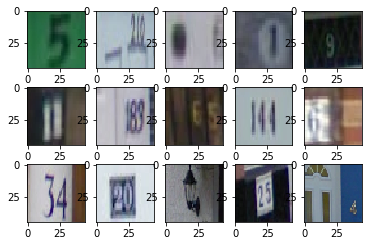

In [287]:
print 'This is the presentation of the bounding box predictor in testing set'
for j in range(15):
    plt.subplot(3, 5, j+1)
    plt.imshow(X_croped[j])

In [288]:
right_count = np.zeros((6))
right_total = 0
# Caculate accuracy
for i in range(nb_predict):
    right_digit = 0
    for j in range(6):
        if np.argmax(y_prediction[j][i]) == np.argmax(y_test[j][i]):
            right_count[j] += 1
            right_digit += 1
    if right_digit == 6:
        right_total+=1
print right_count
#acc = right_count / X_croped.shape[0]
print right_count/nb_predict
print 'Acc:%f'%(float(right_total)/X_croped.shape[0])
#model2.evaluate(X_croped, y_test)
#X_croped.shape


[  2957.   1856.   5132.   9501.   9998.  10000.]
[ 0.2957  0.1856  0.5132  0.9501  0.9998  1.    ]
Acc:0.052900


### Question 10
_How well does your model localize numbers on the testing set from the realistic dataset? Do your classification results change at all with localization included?_

**Answer:**
- It is also not very good. You can see the performance above. Uh...it just change a little, a little little...
- At begining, I trained a model with 5 regressesion predictor that predicted the bbox of each digit respectively and a softmax classfier that predicted the length of the digits. I got a high loss in second and third predictor. I tried more complicated and more simple structure, but the improvement is unconspicuous. Finally, I decided to reformate the labels so that made the model predict the bounding box of all digit instead of each digit.
- Yes, with localization included, the predictions of the first and third one are right.

### Question 11
_Test the localization function on the images you captured in **Step 3**. Does the model accurately calculate a bounding box for the numbers in the images you found? If you did not use a graphical interface, you may need to investigate the bounding boxes by hand._ Provide an example of the localization created on a captured image.

**Answer:**
It calculated right bounding boxes for No.1, No.2, No.3 and No.5 picture and failed for No.4. The example of the localization is above the questions.

----
## Optional Step 5: Build an Application or Program for a Model
Take your project one step further. If you're interested, look to build an Android application or even a more robust Python program that can interface with input images and display the classified numbers and even the bounding boxes. You can for example try to build an augmented reality app by overlaying your answer on the image like the [Word Lens](https://en.wikipedia.org/wiki/Word_Lens) app does.

Loading a TensorFlow model into a camera app on Android is demonstrated in the [TensorFlow Android demo app](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android), which you can simply modify.

If you decide to explore this optional route, be sure to document your interface and implementation, along with significant results you find. You can see the additional rubric items that you could be evaluated on by [following this link](https://review.udacity.com/#!/rubrics/413/view).

### Optional Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Your optional code implementation goes here.
### Feel free to use as many code cells as needed.

### Documentation
Provide additional documentation sufficient for detailing the implementation of the Android application or Python program for visualizing the classification of numbers in images. It should be clear how the program or application works. Demonstrations should be provided. 

_Write your documentation here._

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.